In [ ]:
import numpy as np
import os
import glob
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## All features for Emiliani2 with target Emiliani2 VHI

In [ ]:
target_region = 'Emiliani2'
csv_with_aggreg = "./features_with_aggregations_" + target_region + ".csv"

In [ ]:
all_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})

In [ ]:
# merge with target values of Emiliani2
csv_target = "./csv/Emiliani2.csv"
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})

# remove dates not available in features
target = target[target['date'] <= all_features['date'].iloc[-1]]

target_df = pd.merge(all_features, target, on=['date'])['mean'].to_frame()

In [ ]:
target_df['mean_diff'] = target_df['mean'] - target_df['mean'].shift(1)
target_df['mean_diff'][0] = target_df['mean'][0] # the first value ha been left unchanged

In [ ]:
target_df.head()

,mean,mean_diff
0,0.214281,0.214281
1,0.484737,0.270456
2,0.466071,-0.018666
3,0.417470,-0.048601
4,0.492202,0.074732


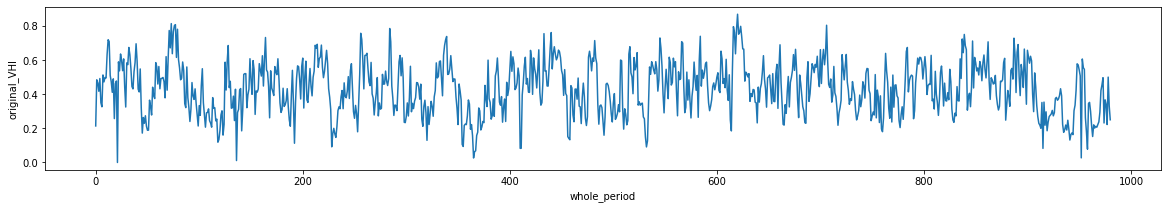

In [ ]:
plt.ylabel("original_VHI")
plt.xlabel("whole_period")
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(target_df['mean'])

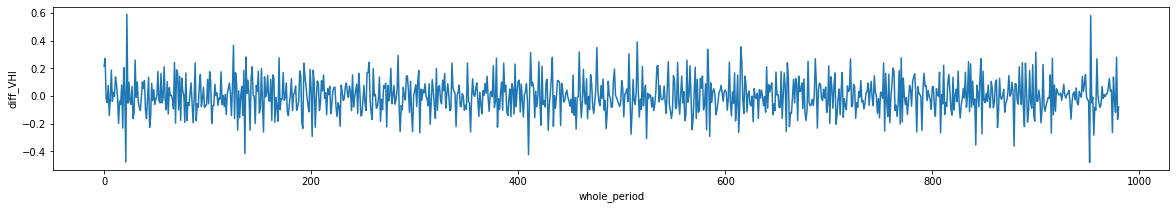

In [ ]:
plt.ylabel("diff_VHI")
plt.xlabel("whole_period")
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(target_df['mean_diff'])

In [ ]:
target_df = target_df.iloc[:,1:]

In [ ]:
# remove the date column
features_df = all_features.iloc[:,1:]

In [ ]:
idx_dic = {}
for col in features_df.columns:
    idx_dic[col] = features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_Emiliani2_tg
1: cyclostationary_mean_Emiliani2_rr
2: cyclostationary_mean_Emiliani2_tg_1w
3: cyclostationary_mean_Emiliani2_tg_4w
4: cyclostationary_mean_Emiliani2_tg_8w
5: cyclostationary_mean_Emiliani2_tg_12w
6: cyclostationary_mean_Emiliani2_tg_16w
7: cyclostationary_mean_Emiliani2_tg_24w
8: cyclostationary_mean_Emiliani2_rr_1w
9: cyclostationary_mean_Emiliani2_rr_4w
10: cyclostationary_mean_Emiliani2_rr_8w
11: cyclostationary_mean_Emiliani2_rr_12w
12: cyclostationary_mean_Emiliani2_rr_16w
13: cyclostationary_mean_Emiliani2_rr_24w


# Feature Selection and linear regression

### Prepare pickle file for FS algorithm, with only the training set

In [ ]:
# features selection done only on training set
n = 0.6

features_train = features_df.iloc[0:round(len(features_df)*n)]
len(features_train)

589

In [ ]:
target_train = target_df[0:round(len(target_df)*n)]
len(target_train)

589

In [ ]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features_train.values)
scaled_train_target = scaler.fit_transform(target_train.values)

In [ ]:
output = { "X" : scaled_train_features, "Y" : scaled_train_target}

with open("./pickles/targetEmiliani2.pickle", "wb") as f:
    pickle.dump(output, f)

### FS algorithm with different parameters values

#### k = 3

In [ ]:
# Delta: 0.005, 0.01, 0.03, 0.05, 0.1 final number of features: 6, selected features IDs: [1, 8]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 3

#### k = 10

In [ ]:
# Delta: 0.005, 0.01, 0.03, 0.05, 0.1 final number of features: 1, selected features IDs: [3, 1]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 10

#### k = 25

In [ ]:
# Delta: 0.005, 0.01, 0.03, 0.05, 0.1 final number of features: 1, selected features IDs: [11, 1]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 25

#### k = 100

In [ ]:
# Delta: 0.005, 0.01, 0.03, 0.05, 0.1 final number of features: 1, selected features IDs: [1,13]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 100

## Linear Regression

In [ ]:
scaler_f = StandardScaler()
scaler_t = StandardScaler()

In [ ]:
train_perc=0.6
tot_rows = len(features_df)
valid_perc = 0.2

features_train = features_df.iloc[0:round(tot_rows*train_perc),:]
target_train = target_df.iloc[0:round(tot_rows*train_perc),:]

# fit the scalers on training data
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# scale all the dataset
features_df[features_df.columns] = scaler_f.transform(features_df[features_df.columns])
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

X_train = features_df.iloc[0:round(tot_rows*train_perc),:]
X_valid = features_df.iloc[round(tot_rows*train_perc):round(tot_rows*(valid_perc+train_perc))]
X_test = features_df.iloc[round(tot_rows*(valid_perc+train_perc)):]

y_train = target_df.iloc[0:round(tot_rows*train_perc),:]
y_valid = target_df.iloc[round(tot_rows*train_perc):round(tot_rows*(valid_perc+train_perc))]
y_test = target_df.iloc[round(tot_rows*(valid_perc+train_perc)):]

X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train,y_valid])

print("Total numer of samples: ", len(features_df))
print("Train samples: ", len(y_train))
print("Validation samples and test samples: ", len(y_valid))
print("Training and validation samples: ", len(y_train_valid))

Total numer of samples:  981
Train samples:  589
Validation samples and test samples:  196
Training and validation samples:  785


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# tutte le features
X_train_all = X_train_valid

X_test_all = X_test

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
reg = LinearRegression().fit(X_train_all, y_train_valid)
print("All features linear regression: ")
print("R2_train: ", round(reg.score(X_train_all, y_train_valid),3))
#print(mean_squared_error(y_train,reg.predict(X_train_all),squared=False))
print("R2_test: ", round(reg.score(X_test_all, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test_all)),3))
#print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test_all),squared=False),3))
print('\n')
# delta piccolo
print("Chosen features linear regression: ")
X_train_regr = X_train_all.iloc[:,[11, 1]]
X_test_regr = X_test_all.iloc[:,[11, 1]]
reg = LinearRegression().fit(X_train_regr, y_train_valid)
print("R2_train: ", round(reg.score(X_train_regr, y_train_valid), 3))
print("R2_test: ", round(reg.score(X_test_regr, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test_regr)),3))

All features linear regression: 
R2_train:  0.134
R2_test:  -0.035
MAE:  0.78


Chosen features linear regression: 
R2_train:  0.037
R2_test:  0.02
MAE:  0.736


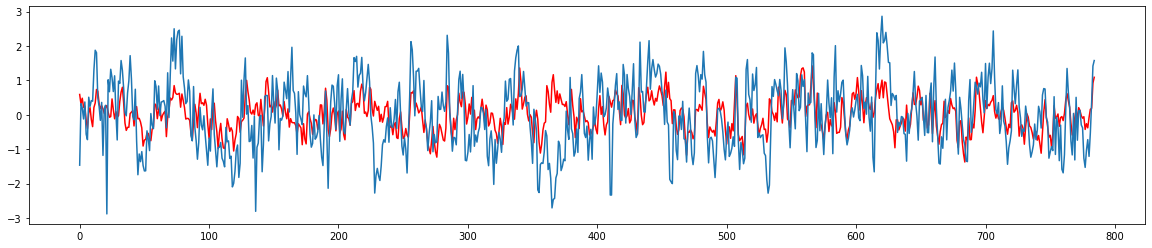

In [ ]:
#before

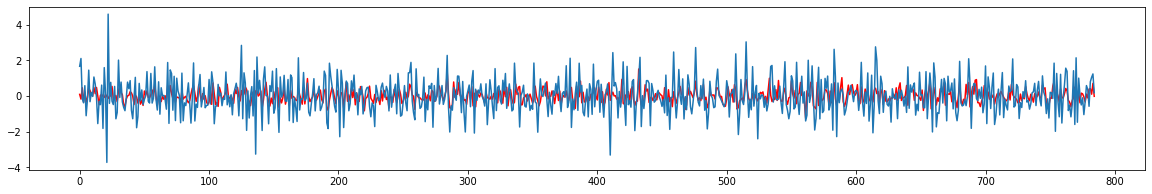

In [ ]:
import matplotlib.pyplot as plt

reg = LinearRegression().fit(X_train_all, y_train_valid)
# plot prediction on train
prediction = reg.predict(X_train_all)

plt.plot(prediction, color='red')
plt.plot(y_train_valid)

plt.rcParams["figure.figsize"] = (20,4)

plt.show()

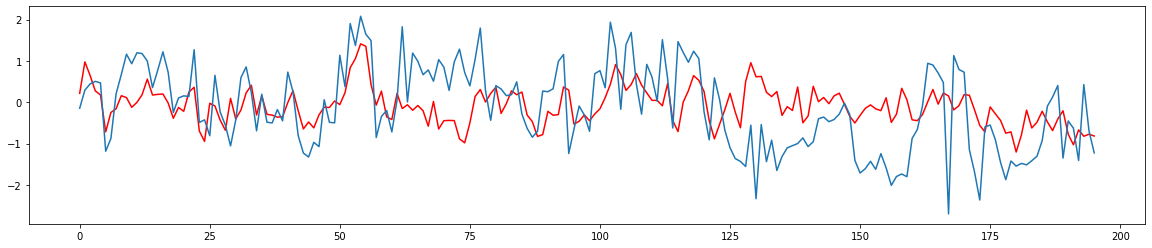

In [ ]:
# before 

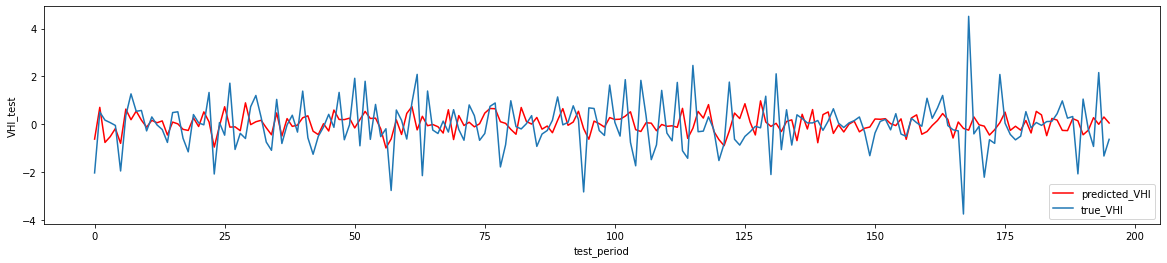

In [ ]:
prediction = reg.predict(X_test_all)

plt.plot(prediction, color='red', label ="predicted_VHI")
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test, label = "true_VHI")

plt.ylabel("VHI_test")
plt.xlabel("test_period")

plt.legend(loc="lower right")

plt.rcParams["figure.figsize"] = (15,4)
plt.show()

# Non linear models

## Imports and functions

In [ ]:
! pip install tensorflow_addons
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import GridSearchCV

np.random.seed(1724)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [52]:
def feed_forward(num_units):
  # learning rate
  lr = 1e-3

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=num_units, activation=tf.keras.activations.relu))
  model.add(tf.keras.layers.Dense(units = 1))

  metrics = [tf.keras.metrics.MeanAbsoluteError()]

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                loss='mse',
                metrics=metrics)
  
  return model

## With all features

### Extra Tree Regressor

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 120, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
len(X_train_valid)

In [ ]:
X_train_valid

In [ ]:
ext = ExtraTreesRegressor(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 2)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(X_train_valid.values, y_train_valid.values.ravel())

In [ ]:
opt.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 117}

In [ ]:
rfc= ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 117)

rfc.fit(X_train_valid.values, y_train_valid.values.ravel())

ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=117,
                    random_state=42)

In [ ]:
rf_mae = mean_absolute_error(y_test.values.ravel(), rfc.predict(X_test.values))
rf_mse = mean_squared_error(y_test.values.ravel(), rfc.predict(X_test.values))
r2_test = rfc.score(X_test.values, y_test.values.ravel())
r2_train = rfc.score(X_train_valid.values, y_train_valid.values.ravel())

print(" ExtraTreesRegressor: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor: 
 MAE:  0.736 
 MSE:  1.053 
 R2_test:  0.001 
 R2_train:  0.734


### FFNN

In [53]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

hist_val = ffnn_val.fit(X_train.values, y_train.values, shuffle=False, epochs=300, 
                        validation_data=(X_valid.values, y_valid.values), verbose = 0)

KeyboardInterrupt: ignored

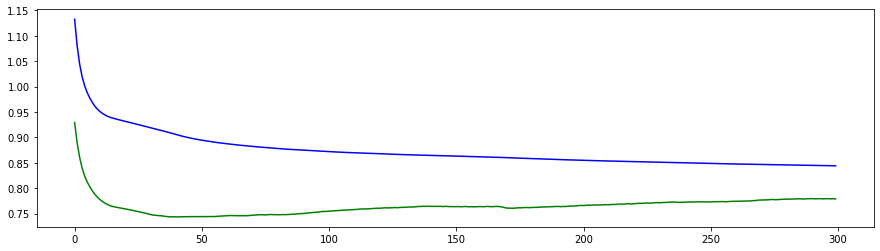

In [ ]:
plt.plot(hist_val.history['loss'], 'b')
plt.plot(hist_val.history['val_loss'],'g')

In [ ]:
ffnn = feed_forward(4)
ffnn.fit(X_train_valid, y_train_valid, shuffle=False, epochs=45, verbose = 0)

In [ ]:
ffnn_MAE = mean_absolute_error(y_test.values, ffnn.predict(X_test.values))
ffnn_MSE = mean_squared_error(y_test.values, ffnn.predict(X_test.values))

metric = RSquare()
metric.update_state(y_test.values, ffnn.predict(X_test.values))
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(y_train_valid, ffnn.predict(X_train_valid))
r2_train = metric.result()
r2_train.numpy()
print (" FFNN:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ",round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

25/25 [==============================] - 0s 1ms/step
 FFNN:
 MAE:  0.76 
 MSE:  1.066 
 R2_test:  -0.011 
 R2_train:  0.12


#Graphs

In [ ]:
X_train = X_train_all.iloc[:,[0, 10, 11, 2, 7, 9]]
X_test = X_test_all.iloc[:,[0, 10, 11, 2, 7, 9]]
reg = LinearRegression().fit(X_train, y_train_regr)

7/7 [==============================] - 0s 2ms/step


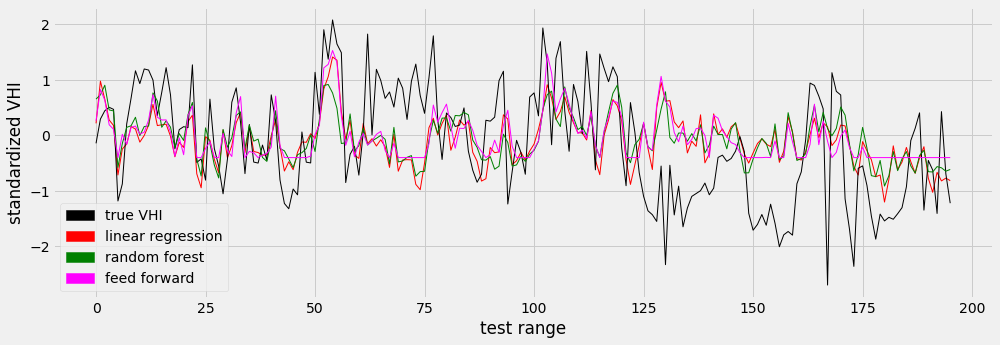

In [ ]:
import matplotlib.patches as mpatches

prediction = reg.predict(X_test)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test, color='black')
random_forest = rfc.predict(scaled_test_features.values)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(scaled_test_features.values)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("test range")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 1
plt.show()

25/25 [==============================] - 0s 2ms/step


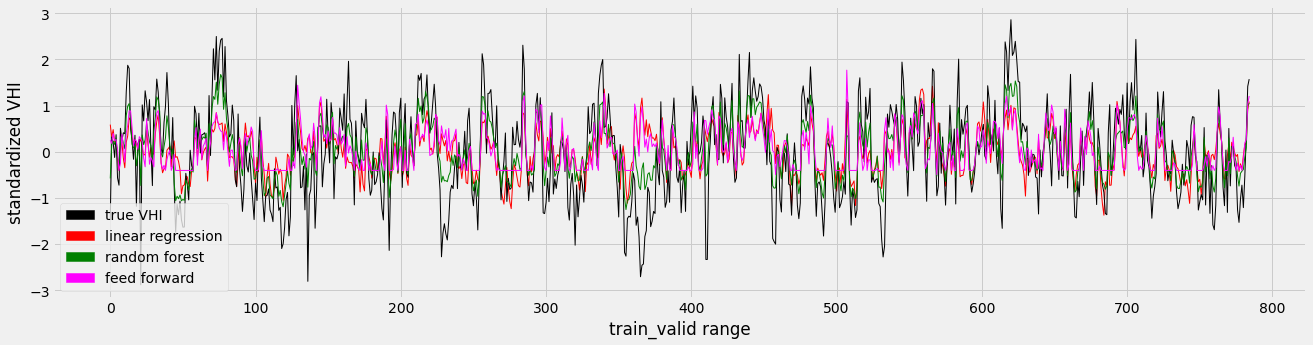

In [ ]:
prediction = reg.predict(X_train)
plt.plot(prediction, color='red')
y_train_regr.reset_index(drop = True, inplace = True)
plt.plot(y_train_regr, color='black')
random_forest = rfc.predict(train_valid_features.values)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(train_valid_features.values)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("train_valid range")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 1
plt.show()